In [1]:
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import scipy.stats as st
import tensorflow as tf
from scipy import signal
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image as image_keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt

# Convolution

Image convolution is an element-wise multiplication of two matrices followed by a sum.

1. Take two matrices
2. Multiply 
3. Sum

Some images also have depth, like an RGB image has depth of 3 for the red, green and blue channels. 

Image is our base matrix, and we take a smaller matrix (kernel/convolutional matrix) and slide it on top of the original image.

![Convolution matrix](https://i.imgur.com/7NcGa8R.png)

Kernel are of size M x N, where M,N are odd integers to make sure the result is a valid integer at the center.

## Image handling

I'm using openCV for loading and handling images, and matplotplib to display the image in jupyter.

Notes:
* opencv uses BGR format, and matplotlib uses RGB so we have to convert BGR to RGB before displaying images.
* For RGB and RGBA images, Matplotlib supports float32 and uint8 data types. For grayscale, Matplotlib supports only float32. 
* Matplotlib plotting can handle float32 and uint8, but image reading/writing for any format other than PNG is limited to uint8 data. Why 8 bits? Most displays can only render 8 bits per channel worth of color gradation
* To stop matplotlib from adjusting pixel scale intensity for gray images, we should use 'cmap='gray', vmin = 0, vmax = 255' arguments.

Calculating padding:
$ P = \dfrac{(F-1)}{2} $, where F = filter size

Before applying the kernel, we have to flip it, otherwise we get a different operation called cross correlation. For symmetric filters it doesn't matter as convolution and correlation result the same.

In [2]:
class Convolution():
    def __init__(self, image_path: str):
        self.src_image = cv2.imread(image_path)
        self.image = cv2.cvtColor(self.src_image, cv2.COLOR_BGR2GRAY)
        self.conv_out = self.image
        
    def conv(self, filters: list):
        self.conv_out = self.image
    
        for _filter in filters:
            self.conv_out = self.__conv(_filter)
        
        return self.conv_out
    
    def show_image(self):
        _, self.ax = plt.subplots(figsize=(10, 10))
        self.ax.imshow(self.image, cmap="gray", vmin = 0, vmax = 255)
        
    def show_conv(self, title):
        _, self.ax = plt.subplots(figsize=(10, 10))
        ax.set_title(title)
        self.ax.imshow(self.conv_out, cmap="gray", vmin = 0, vmax = 255)
                
    def __conv(self, _filter):
        ZERO_PADDING = [0, 0, 0]
        
        img = self.conv_out
        image_height, image_width = self.conv_out.shape
        output = np.zeros(self.conv_out.shape, dtype="float32")
        
        _, filter_size = _filter.shape
        padding = (filter_size - 1) // 2
        
        img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=ZERO_PADDING)

        kernel = np.flip(_filter)
        
        for i in range(padding, image_height + padding):
            for j in range(padding, image_width + padding):
                center = img[i - padding:i + padding + 1, j - padding:j + padding + 1]
                conv_sum = (center * kernel).sum()

                output[i - padding, j - padding] = conv_sum
        
        return output.astype("uint8")

### Example filters
Blur:
* average
* gaussian
* median

Sharpen

Edge detection:
* sobel
* laplacian

In [3]:
class Filter():
    def __init__(self, name, size=3, sig=3.):
        self.name = name
        self.size = size
        
        if name == 'blur':
            self.func = self.__blur(size)
            return
        
        if name == 'sharpen':
            self.func = self.__sharpen()
            return
        
        if name == 'gauss':
            self.func = self.__gauss(size, sig)
            return
        
        if name == 'sobel_x':
            self.func = self.__sobel_x()
            return
        
        if name == 'sobel_y':
            self.func = self.__sobel_y()
            return
                
        if name == 'laplacian':
            self.func = self.__laplacian()
            return
        
        raise ValueError('Filter not found')
        
    def get(self):
        return self.func
        
    def __blur(self, size):
        return np.ones((size, size)) * (1.0 / (size * size))
    
    def __sharpen(self):
        return np.array((
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]))
    
    def __gauss(self, size, sig):
        t = np.linspace(-sig, sig, size + 1)
        _1d = np.diff(st.norm.cdf(t))
        _2d = np.outer(_1d, _1d)
        return _2d / _2d.sum()
    
    def __sobel_x(self):
        return np.array((
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]))
    
    def __sobel_y(self):
        return np.array((
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]))
            
    def __laplacian(self):
        return np.array((
            [0, 1, 0],
            [1, -4, 1],
            [0, 1, 0]))

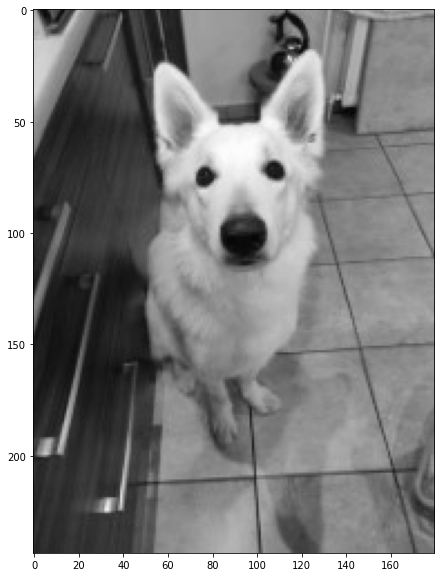

In [4]:
input_image = './example_image/1_small.jpg'

conv = Convolution(input_image)

conv.show_image()

## Box blur

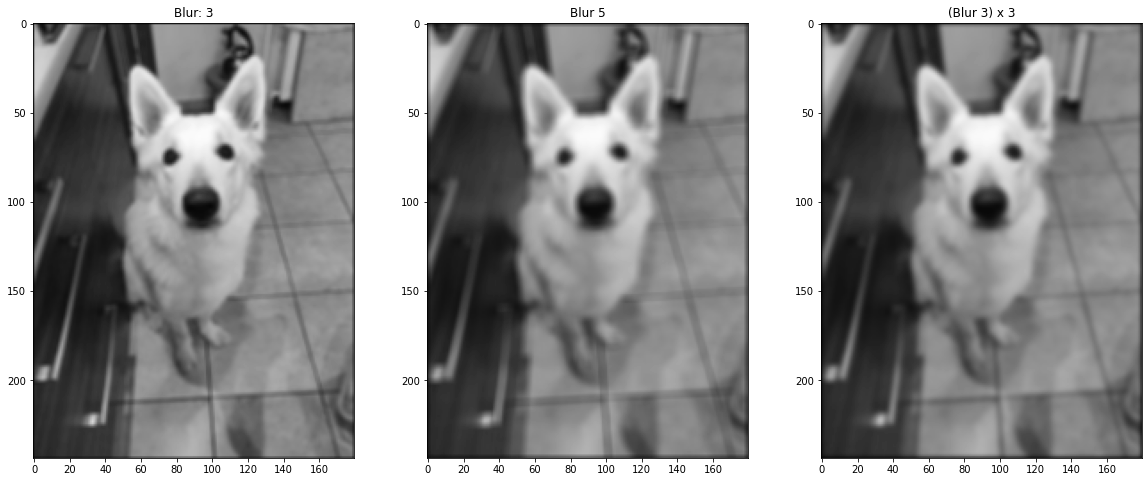

In [9]:
blur_3 = Filter("blur", 3).get()
blur_5 = Filter("blur", 5).get()

out = []
titles = ["Blur: 3", "Blur 5", "(Blur 3) x 3"]

out.append(conv.conv([blur_3]))
out.append(conv.conv([blur_5]))
out.append(conv.conv([blur_3, blur_3, blur_3]))

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

for i in range(len(out)):
    axs[i].imshow(out[i], cmap="gray", vmin = 0, vmax = 255)
    axs[i].set_title(titles[i])

For big images direct convolution takes a long time, so we can use filter2D from openCV.

> The function uses the DFT-based algorithm in case of sufficiently large kernels (~11 x 11 or larger) and the direct algorithm for small kernels.

In [7]:
class ConvolutionCV():
    def __init__(self, image_path: str):
        self.image = cv2.imread(image_path)
        self.conv_out = self.image
        
    def conv(self, kernels: list):
        self.conv_out = self.image
        
        for kernel in kernels:
            self.conv_out = cv2.filter2D(self.conv_out, -1, kernel)
            
        return self.conv_out

    def show_image(self):
        img = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        _, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img)
        
    def show_conv(self, title):
        out = cv2.cvtColor(self.conv_out, cv2.COLOR_BGR2RGB)
        _, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(title)
        ax.imshow(out)

In [8]:
input_image = './example_image/1.jpg'
conCV = ConvolutionCV(input_image)

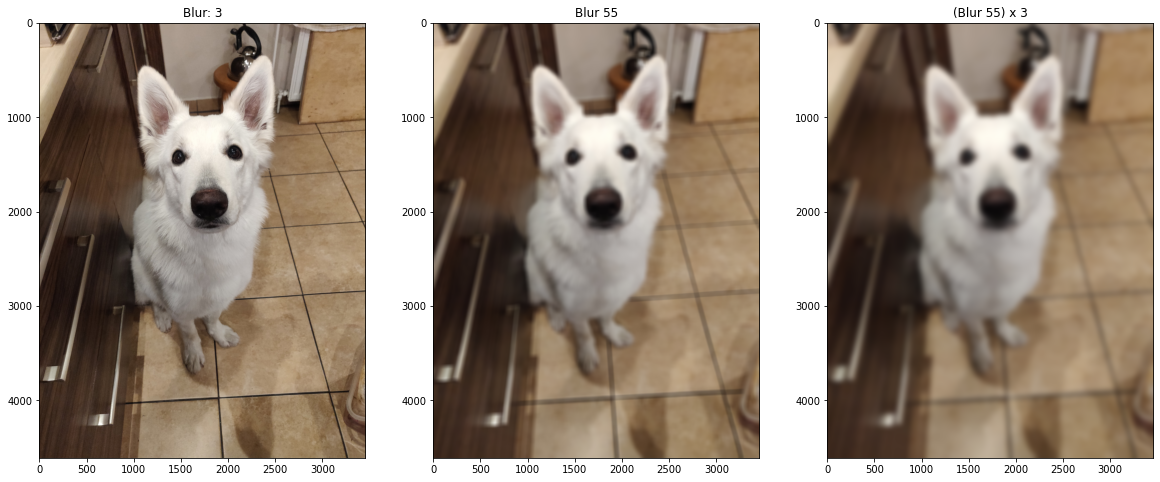

In [24]:
blur_3 = Filter("blur", 3).get()
blur_55 = Filter("blur", 55).get()

out = []
titles = ["Blur: 3", "Blur 55", "(Blur 55) x 3"]

out.append(conCV.conv([blur_3]))
out.append(conCV.conv([blur_55]))
out.append(conCV.conv([blur_55, blur_55, blur_55]))

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

for i in range(len(out)):
    axs[i].imshow(cv2.cvtColor(out[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])

## Sharpen

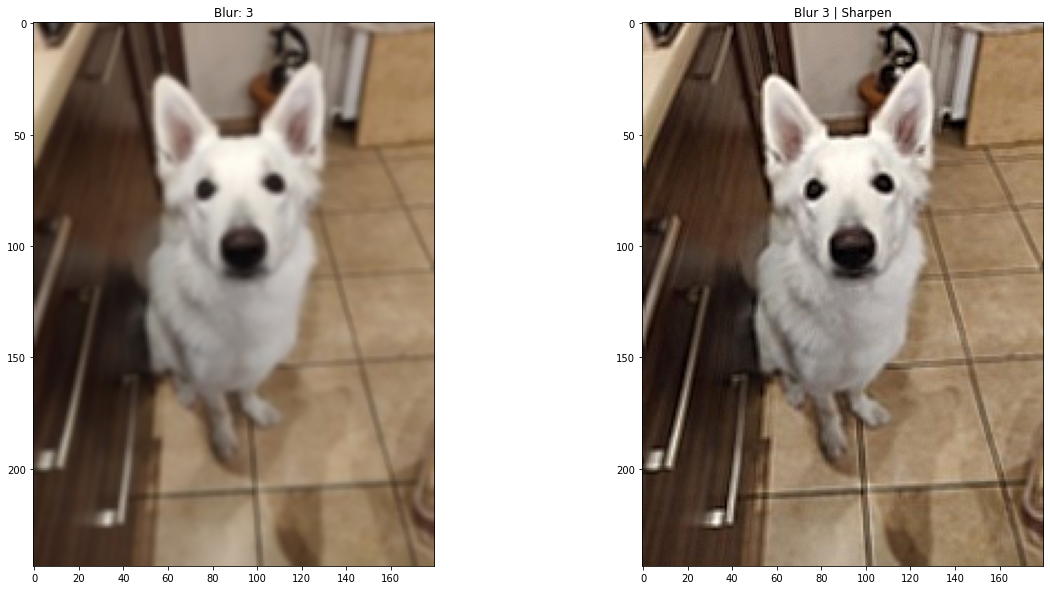

In [13]:
conCV_sm = ConvolutionCV('./example_image/1_small.jpg')

blur_3 = Filter("blur", 3).get()
sp = Filter("sharpen").get()

out = []
titles = ["Blur: 3", "Blur 3 | Sharpen"]

out.append(conCV_sm.conv([blur_3]))
out.append(conCV_sm.conv([blur_3, sp]))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for i in range(len(out)):
    axs[i].imshow(cv2.cvtColor(out[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])

## Gaussian blur

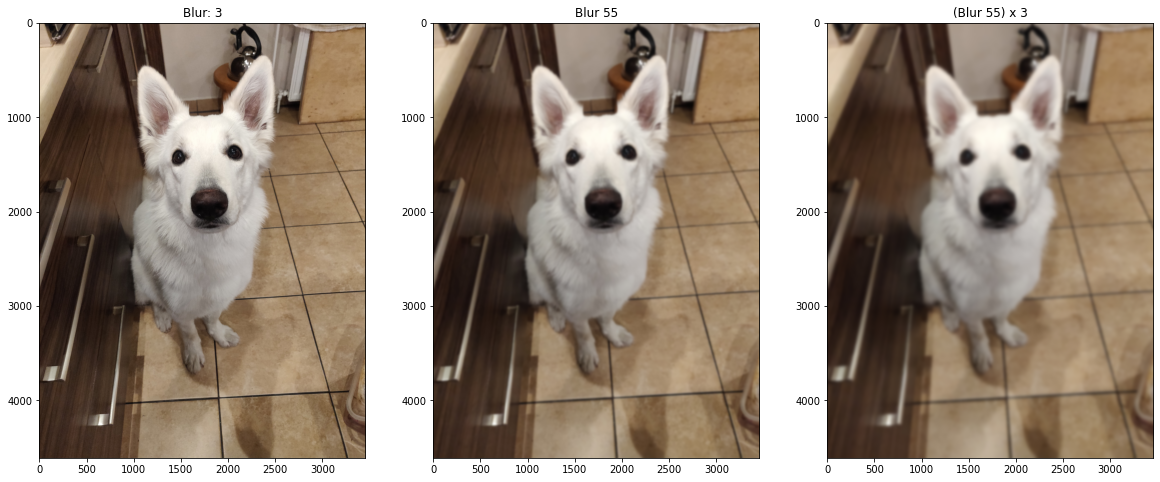

In [9]:
gauss_3 = Filter("gauss", 3).get()
gauss_55 = Filter("gauss", 55).get()

out = []
titles = ["Blur: 3", "Blur 55", "(Blur 55) x 3"]

out.append(conCV.conv([gauss_3]))
out.append(conCV.conv([gauss_55]))
out.append(conCV.conv([gauss_55, gauss_55, gauss_55]))

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

for i in range(len(out)):
    axs[i].imshow(cv2.cvtColor(out[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])

## Sobel

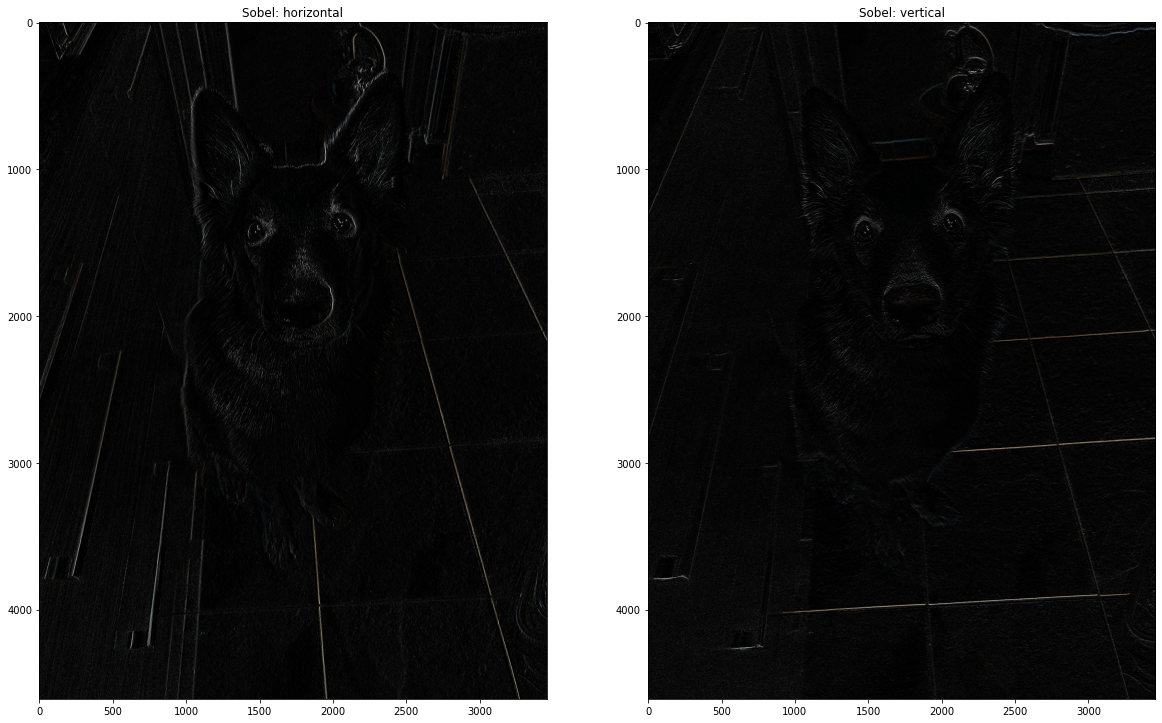

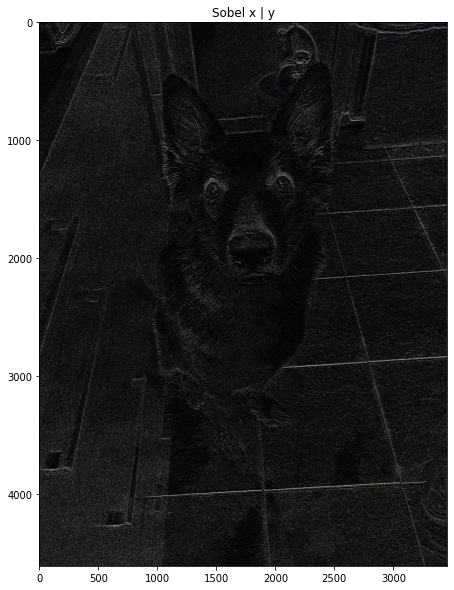

In [10]:
sb_x = Filter("sobel_x").get()
sb_y = Filter("sobel_y").get()

out = []
titles = ["Sobel: horizontal", "Sobel: vertical"]

out.append(conCV.conv([sb_x]))
out.append(conCV.conv([sb_y]))

fig, axs = plt.subplots(1, 2, figsize=(20, 15))

for i in range(len(out)):
    axs[i].imshow(cv2.cvtColor(out[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])
    
conCV.conv([sb_y, sb_y])
conCV.show_conv("Sobel x | y")

## Laplacian

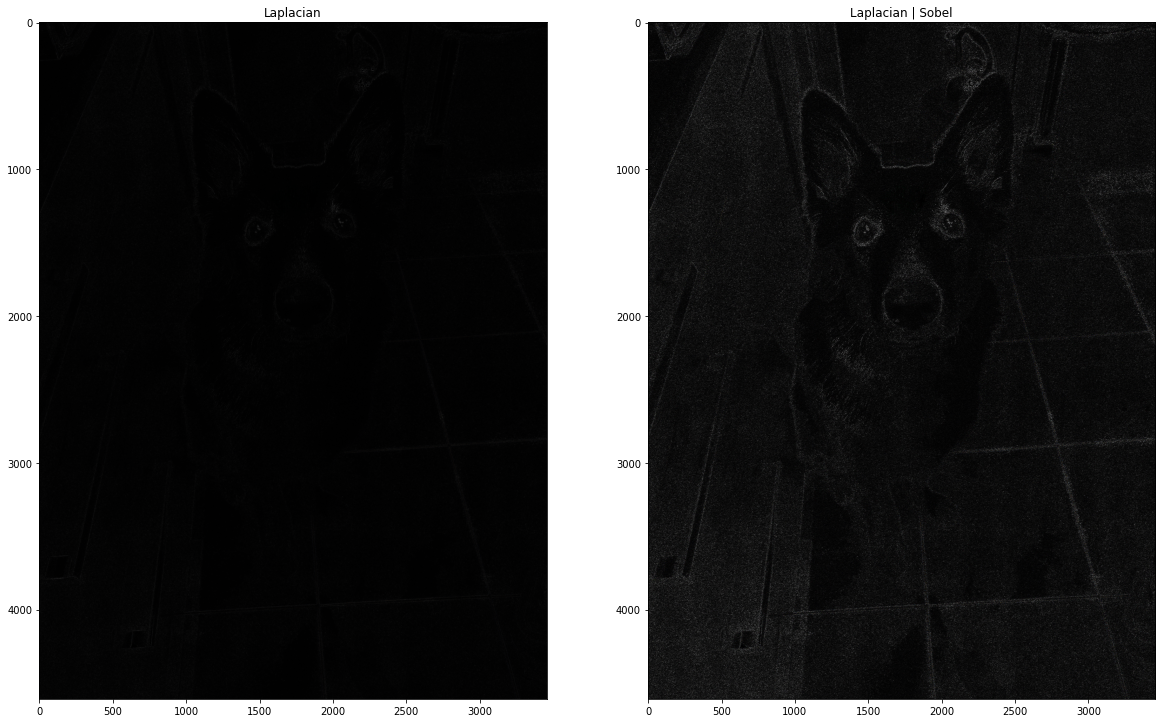

In [11]:
lp = Filter("laplacian").get()

out = []
titles = ["Laplacian", "Laplacian | Sobel"]

out.append(conCV.conv([lp]))
out.append(conCV.conv([lp, sb_x, sb_y]))

fig, axs = plt.subplots(1, 2, figsize=(20, 15))

for i in range(len(out)):
    axs[i].imshow(cv2.cvtColor(out[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])

# CNN

## Dataset

The training archive contains 25,000 images of dogs and cats.

https://www.microsoft.com/en-us/download/details.aspx?id=54765

## Prepare data

File tree:
```
datasets
└──cats_dogs
    ├── Cat
    └── Dog
```

In [12]:
dataset_home = './datasets/cats_dogs'

I had problems with some images, so I added a check if files are not corrupted

In [13]:
for folder in listdir(dataset_home):
    for f in listdir(join(dataset_home, folder)):
        f_path = join(dataset_home, folder, f)
        print('** Path: {}  **'.format(f_path), end="\r", flush=True)
        image = plt.imread(f_path)

C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.

Files I had to delete:
 * Thumbs.db in both folders
 * Cat/666.jpg
 * Dog/11702.jpg

In [14]:
input_shape = (224, 224, 3)
img_width = 224
img_height = 224

batch_size = 32
epochs = 50
lr = 1e-4

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1



In [15]:
datagen = image_keras.ImageDataGenerator(
    rescale=1./255.0, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 30,
    horizontal_flip=True)

train_gen = datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=dataset_home,
                                                 shuffle=True,
                                                 target_size=(img_width, img_height), 
                                                 subset="training",
                                                 class_mode='binary')

validation_gen = datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=dataset_home,
                                                 shuffle=True,
                                                 target_size=(img_width, img_height), 
                                                 subset="validation",
                                                 class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


## Define model

Model defined with three VGG Blocks

The basic building block of classic CNNs is a sequence of the following: (i) a convolutional layer with padding to maintain the resolution, (ii) a nonlinearity such as a ReLU, (iii) a pooling layer such as a maximum pooling layer. One VGG block consists of a sequence of convolutional layers, followed by a maximum pooling layer for spatial downsampling. In the original VGG paper [Simonyan & Zisserman, 2014], the authors employed convolutions with  3×3  kernels with padding of 1 (keeping height and width) and  2×2  maximum pooling with stride of 2 (halving the resolution after each block).

In [16]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

## Compile model

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

## Fit model

In [18]:
checkpoint = ModelCheckpoint("cats_dogs_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [19]:
history = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_gen,
    validation_steps = validation_gen.samples // batch_size)

model.save("cats_dogs_model.h5")
np.save('cats_dogs_history.npy', history.history)

Epoch 1/50
625/625 [==============================] - 272s 432ms/step - loss: 0.7936 - accuracy: 0.5203 - val_loss: 0.6791 - val_accuracy: 0.5605

Epoch 00001: val_loss improved from inf to 0.67909, saving model to cats_dogs_model.h5
Epoch 2/50
625/625 [==============================] - 270s 432ms/step - loss: 0.6559 - accuracy: 0.5937 - val_loss: 0.6293 - val_accuracy: 0.6518

Epoch 00002: val_loss improved from 0.67909 to 0.62928, saving model to cats_dogs_model.h5
Epoch 3/50
625/625 [==============================] - 268s 430ms/step - loss: 0.6219 - accuracy: 0.6356 - val_loss: 0.6081 - val_accuracy: 0.6753

Epoch 00003: val_loss improved from 0.62928 to 0.60814, saving model to cats_dogs_model.h5
Epoch 4/50
625/625 [==============================] - 269s 430ms/step - loss: 0.5925 - accuracy: 0.6767 - val_loss: 0.5758 - val_accuracy: 0.6791

Epoch 00004: val_loss improved from 0.60814 to 0.57582, saving model to cats_dogs_model.h5
Epoch 5/50
625/625 [==============================] 

In [2]:
model = models.load_model("cats_dogs_model.h5")
history = np.load('cats_dogs_history.npy', allow_pickle='TRUE').item()

In [3]:
history

{'loss': [0.7052954435348511,
  0.6462718844413757,
  0.6162731051445007,
  0.5863988995552063,
  0.5619943737983704,
  0.5454452037811279,
  0.5259109139442444,
  0.5148932933807373,
  0.5049290657043457,
  0.4905187487602234,
  0.4818045496940613,
  0.4743513762950897,
  0.4691055119037628,
  0.46110936999320984,
  0.4526793360710144,
  0.44452735781669617,
  0.44336313009262085,
  0.4343964457511902,
  0.4298133850097656,
  0.4300135374069214,
  0.4233762323856354,
  0.4134366810321808,
  0.41031646728515625,
  0.4015742540359497,
  0.4019702672958374,
  0.39694151282310486,
  0.39101991057395935,
  0.39218568801879883,
  0.38577625155448914,
  0.3803868889808655,
  0.37635108828544617,
  0.3773547112941742,
  0.37240445613861084,
  0.3668304979801178,
  0.361865371465683],
 'accuracy': [0.5394999980926514,
  0.6102499961853027,
  0.6499999761581421,
  0.6819499731063843,
  0.7031499743461609,
  0.7142500281333923,
  0.7303000092506409,
  0.7390000224113464,
  0.7494999766349792,
  

## Evaluate model

In [5]:
def plot_loss(his):
    loss_values = his['loss']
    val_loss_values = his['val_loss']
    epochs = range(1, len(loss_values) + 1)

    line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
    line2 = plt.plot(epochs, loss_values, label='Training Loss')
    plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
    
def plot_acc(his):
    acc_values = his['accuracy']
    acc_loss_values = his['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    line1 = plt.plot(epochs, acc_loss_values, label='Validation/Test Accuracy')
    line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
    plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

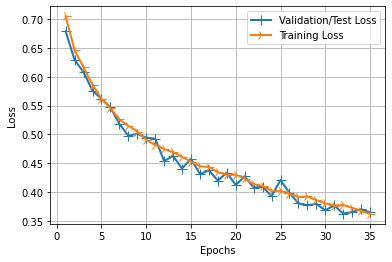

In [23]:
plot_loss(history)

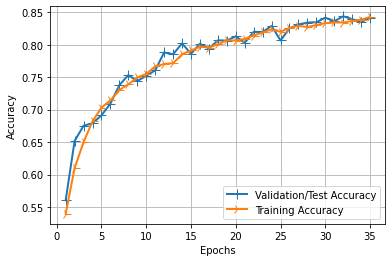

In [6]:
plot_acc(history)

In [25]:
def load_image(filename):

    im = image_keras.load_img(filename)
    plt.imshow(im)

    im = image_keras.load_img(filename, target_size=(img_width, img_height))
    
    im_tensor = image_keras.img_to_array(im)
    im_tensor = im_tensor / 255
    im_tensor = np.expand_dims(im_tensor, axis=0)
    
    return im_tensor

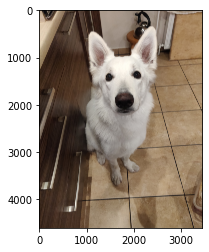

In [26]:
im_tensor = load_image('./example_image/1.jpg')

In [27]:
layer_outputs = [layer.output for layer in model.layers]

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(im_tensor)

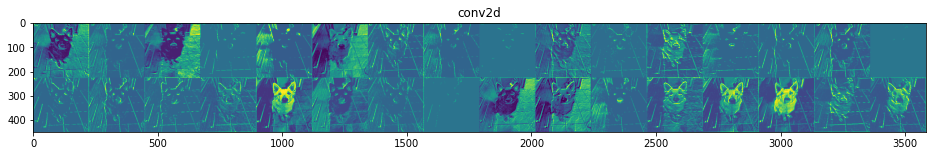

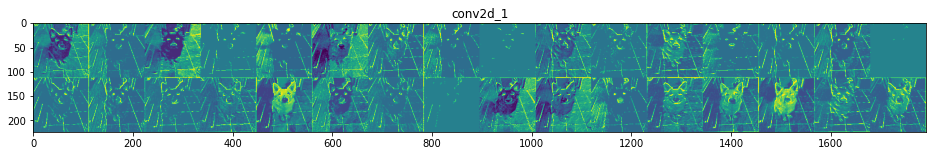

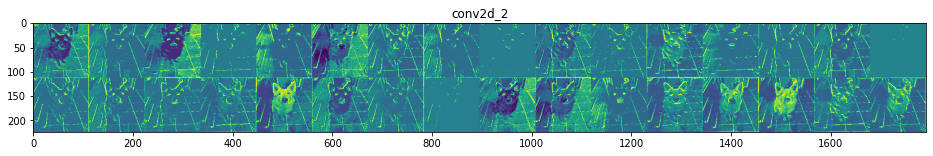

In [28]:
layer_names = []

for layer in model.layers[:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Get CONV layers only
conv_layer_names = []
for layer_name in layer_names:
    if 'conv2d' in layer_name:
        conv_layer_names.append(layer_name)

for layer_name, layer_activation in zip(conv_layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Predict with model

In [29]:
def get_prediction(img):
    cat_id = train_gen.class_indices['Cat']
    dog_id = train_gen.class_indices['Dog']
    im_id = (model.predict(img) > 0.5).astype("int32")[0][0]

    if im_id == cat_id: return 'Cat'
    if im_id == dog_id: return 'Dog'

    return '-1'

'Dog'

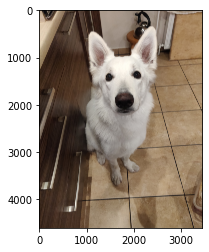

In [30]:
dog = load_image('./example_image/1.jpg')
get_prediction(dog)

'Cat'

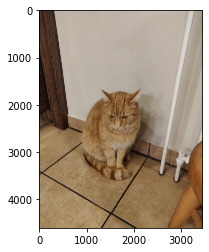

In [31]:
cat = load_image('./example_image/2.jpg')
get_prediction(cat)

# Transfer learning - VGG16

Keras provides pre-trained models that we can use with https://keras.io/api/applications/

In [97]:
def print_layers(layers):
    for (i, layer) in enumerate(layers):
        print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [98]:
from tensorflow.keras.applications import VGG16

vgg16_full = VGG16(weights = 'imagenet', 
                 include_top = True)

print_layers(vgg16_full.layers)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True
19 Flatten True
20 Dense True
21 Dense True
22 Dense True


We can keep the feature extractor of the imported model, and change the top layers that are the classifier made of fully connected layers and the output layer.

In [99]:
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape)

In [100]:
print_layers(vgg16.layers)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


The loaded model ends after the last VGG block instead of importing the whole model.

Freezing layers

In [101]:
vgg16.trainable = False

print_layers(vgg16.layers)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [102]:
print(vgg16.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [103]:
layers = vgg16.output

transfer_model = models.Sequential([
    vgg16,
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

print(transfer_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [104]:
transfer_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [105]:
checkpoint = ModelCheckpoint("cats_dogs_transfer_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [106]:
transfer_history = transfer_model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_gen,
    validation_steps = validation_gen.samples // batch_size)

transfer_model.save("cats_dogs_transfer_model.h5")
np.save('cats_dogs_transfer_history.npy', transfer_history.history)

Epoch 1/50
625/625 [==============================] - 345s 551ms/step - loss: 0.3548 - accuracy: 0.8403 - val_loss: 0.2250 - val_accuracy: 0.9014

Epoch 00001: val_loss improved from inf to 0.22501, saving model to cats_dogs_transfer_model.h5
Epoch 2/50
625/625 [==============================] - 320s 512ms/step - loss: 0.2285 - accuracy: 0.9009 - val_loss: 0.2412 - val_accuracy: 0.8908

Epoch 00002: val_loss did not improve from 0.22501
Epoch 3/50
625/625 [==============================] - 289s 462ms/step - loss: 0.2074 - accuracy: 0.9119 - val_loss: 0.2068 - val_accuracy: 0.9125

Epoch 00003: val_loss improved from 0.22501 to 0.20676, saving model to cats_dogs_transfer_model.h5
Epoch 4/50
625/625 [==============================] - 285s 457ms/step - loss: 0.1965 - accuracy: 0.9188 - val_loss: 0.1892 - val_accuracy: 0.9189

Epoch 00004: val_loss improved from 0.20676 to 0.18916, saving model to cats_dogs_transfer_model.h5
Epoch 5/50
625/625 [==============================] - 285s 455ms/

In [7]:
transfer_model = models.load_model("cats_dogs_transfer_model.h5")
transfer_history = np.load('cats_dogs_transfer_history.npy', allow_pickle='TRUE').item()

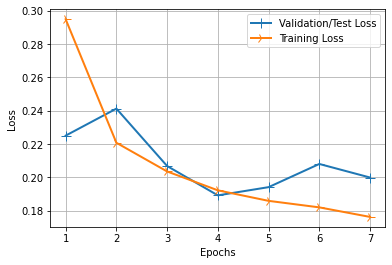

In [108]:
plot_loss(transfer_history)

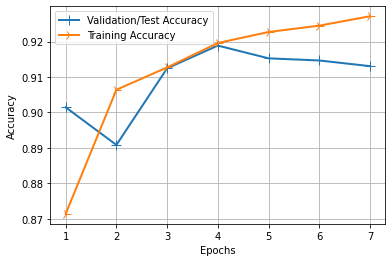

In [8]:
plot_acc(transfer_history)